# Modelling of France Accidents

**Cohort:** mar23_accidents

**Author:** Tobias Schulze

**Date:** 14 September 2023



## Loading of required libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from datetime import datetime
import re

## Importing the data

In [2]:
df = pd.read_csv('./data/230907_basic_table_for_analysis_cleaned.csv', low_memory = False, index_col = 0)

## Data description
### Data

In [3]:
df.head()

,num_veh,place,catu,grav,sexe,an_nais,trajet,locp,actp,etatp,...,obs,obsm,choc,manv,date,is_holiday,holiday,secu_used,secu_avail,fatal
Num_Acc,,,,,,,,,,,,,,,,,,,,,
201900000001,B01,2.0,2,4,2,2002.0,0.0,-1.0,-1,-1.0,...,0.0,2.0,5.0,23.0,2019-11-30,False,NaN,3,1,0
201900000001,B01,1.0,1,4,2,1993.0,5.0,-1.0,-1,-1.0,...,0.0,2.0,5.0,23.0,2019-11-30,False,NaN,3,1,0
201900000001,A01,1.0,1,1,1,1959.0,0.0,-1.0,-1,-1.0,...,1.0,0.0,3.0,11.0,2019-11-30,False,NaN,3,1,0
201900000002,A01,1.0,1,4,2,1994.0,0.0,-1.0,-1,-1.0,...,4.0,0.0,1.0,0.0,2019-11-30,False,NaN,3,1,0
201900000003,A01,1.0,1,1,1,1996.0,0.0,-1.0,0,-1.0,...,0.0,2.0,1.0,2.0,2019-11-28,False,NaN,3,1,0


### Data types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2509596 entries, 201900000001 to 201800057783
Data columns (total 46 columns):
 #   Column        Dtype  
---  ------        -----  
 0   num_veh       object 
 1   place         float64
 2   catu          int64  
 3   grav          int64  
 4   sexe          int64  
 5   an_nais       float64
 6   trajet        float64
 7   locp          float64
 8   actp          object 
 9   etatp         float64
 10  an            int64  
 11  mois          int64  
 12  jour          int64  
 13  hrmn          object 
 14  lum           int64  
 15  agg           int64  
 16  int           int64  
 17  atm           float64
 18  col           float64
 19  adr           object 
 20  lat           float64
 21  long          float64
 22  dep           int64  
 23  metropolitan  float64
 24  catr          float64
 25  circ          float64
 26  nbv           float64
 27  vosp          float64
 28  prof          float64
 29  plan          float64
 30  surf   

### Missing data

In [5]:
df.isna().sum()

num_veh               0
place                 0
catu                  0
grav                  0
sexe                  0
an_nais               0
trajet                0
locp                  0
actp                  0
etatp                 0
an                    0
mois                  0
jour                  0
hrmn                  0
lum                   0
agg                   0
int                   0
atm                   0
col                   0
adr              343702
lat             1065871
long            1073114
dep                   0
metropolitan          0
catr                  0
circ                  0
nbv                   0
vosp                  0
prof                  0
plan                  0
surf                  0
infra                 0
situ                  0
senc                  0
catv                  0
occutc                0
obs                   0
obsm                  0
choc                  0
manv                  0
date                  0
is_holiday      

## Data preparation
### Transform data types
#### Date and time variables
The date and time variables are maybe important as grouping variables or as contrains for time dependent severity of accidents.

For the grouping, a timestamp is required for unbiased identification time related accidents.

_Problem_:

During the transformation of the `hrmn` variable, I got aware, that the string contain integers like `1`,  `801`, or `1300`. Hence, anytime during data conversion, the colon got lost and the values got truncated. Hence `1` should be `00:01` and so on. Therefore, we need an additional transformation of the truncated data to `h:m` format.

**Steps:**
1. Fixing the truncated values in `hrmn`
3. Creation of a `datatime` variable in format y-m-d hh:mm
4. Transformation of the datatime varible to a `timestamp` variable


In addition, we need to transform the type of `an_nais` to integer and `date` to `date`.

In [6]:
# Fixing the hrmn issue:
# Remove the colon
df['hrmn'] = df.apply(lambda x: re.sub(string=x['hrmn'], pattern=':', repl=''), axis = 1)

# Pad the string to four zeros
df['hrmn'] = df.apply(lambda x: x['hrmn'].zfill(4), axis = 1)

# Transform the variable to 'hh:mm' and split to hours and minutes
df = df.assign(hrmn = pd.to_datetime(df['hrmn'], format='%H%M').dt.strftime('%H:%M'))

# Create the daytime variable
df['datetime'] = df.apply(lambda x: datetime(x['an'], x['mois'], x['jour'], datetime.strptime(x['hrmn'], "%H:%M").hour, datetime.strptime(x['hrmn'], "%H:%M").minute), axis = 1)

# Create the timestamp
df['timestamp'] = df.apply(lambda x: datetime.timestamp(x['datetime']), axis = 1)

# Transform `an_nais`
df['an_nais'] = df['an_nais'].astype('int')

# Transform `date`
df = df.assign(date = pd.to_datetime(df['date'], format='mixed'))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2509596 entries, 201900000001 to 201800057783
Data columns (total 48 columns):
 #   Column        Dtype         
---  ------        -----         
 0   num_veh       object        
 1   place         float64       
 2   catu          int64         
 3   grav          int64         
 4   sexe          int64         
 5   an_nais       int64         
 6   trajet        float64       
 7   locp          float64       
 8   actp          object        
 9   etatp         float64       
 10  an            int64         
 11  mois          int64         
 12  jour          int64         
 13  hrmn          object        
 14  lum           int64         
 15  agg           int64         
 16  int           int64         
 17  atm           float64       
 18  col           float64       
 19  adr           object        
 20  lat           float64       
 21  long          float64       
 22  dep           int64         
 23  metropolitan  float64

### Drop variables
The dataset still contains variables with missing values. Some of them are important for possible mapping or a fine granulated classification.

- `adr`: The address variable has missing values and is very fuzzy, so encoding might not be successfully.

- `lat` and `lat`: not available for all sites

- `holiday`: classifies the holiday, but will be used only, if `is_holiday` is relevant

- `grav`: granulated classification of the target `fatal`

- `datetime`: encoded in `timestamp`

In [8]:
columns_drop = ['adr', 'lat', 'long', 'holiday', 'grav', 'datetime']

df.drop(columns = columns_drop, inplace = True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2509596 entries, 201900000001 to 201800057783
Data columns (total 42 columns):
 #   Column        Dtype         
---  ------        -----         
 0   num_veh       object        
 1   place         float64       
 2   catu          int64         
 3   sexe          int64         
 4   an_nais       int64         
 5   trajet        float64       
 6   locp          float64       
 7   actp          object        
 8   etatp         float64       
 9   an            int64         
 10  mois          int64         
 11  jour          int64         
 12  hrmn          object        
 13  lum           int64         
 14  agg           int64         
 15  int           int64         
 16  atm           float64       
 17  col           float64       
 18  dep           int64         
 19  metropolitan  float64       
 20  catr          float64       
 21  circ          float64       
 22  nbv           float64       
 23  vosp          float64

### Encoding
For the first trial, use the `LabelEncoder` to encode categorial values. Then drop the old categorial values and replace them by the encoded.

In [10]:
# Encoding with LabelEncoder
encode_columns = ['actp', 'num_veh', 'hrmn', 'date']
encoded_df = df[encode_columns]
encoded_df = encoded_df.astype('str')
encoded_df = encoded_df.apply(LabelEncoder().fit_transform)

# Merge encoded values
df_encoded = df
df_encoded.drop(encode_columns, inplace=True, axis=1)
df_encoded = pd.concat([encoded_df, df_encoded], axis=1)


### Filtering
It was decided to use only accidents in metropolitan France and Corse.

In preprocessing, the varible `metropolitan` with values `[0,1]` was created.

Now, the data is fitered by this variable and then it is dropped.

In [11]:
df_encoded = df_encoded.loc[df_encoded['metropolitan'] == 1]
df_encoded.drop('metropolitan', inplace=True, axis=1)

In [12]:
df_encoded.isna().sum()

actp          0
num_veh       0
hrmn          0
date          0
place         0
catu          0
sexe          0
an_nais       0
trajet        0
locp          0
etatp         0
an            0
mois          0
jour          0
lum           0
agg           0
int           0
atm           0
col           0
dep           0
catr          0
circ          0
nbv           0
vosp          0
prof          0
plan          0
surf          0
infra         0
situ          0
senc          0
catv          0
occutc        0
obs           0
obsm          0
choc          0
manv          0
is_holiday    0
secu_used     0
secu_avail    0
fatal         0
timestamp     0
dtype: int64

## Data analysis
### Correlation matrix
To get a first glimpse on the possible contrains in the data, a correlation matrix is plotted.

The data variables are dropped to remove redundany with `timestamp`.

In [13]:
# Drop columns for the correlation matrix

columns_drop = ['an', 'mois', 'jour', 'date']
df_select = df_encoded.drop(columns_drop, axis = 1)

In [14]:
# Scale the data
scaler = MinMaxScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_select), columns=df_select.columns)

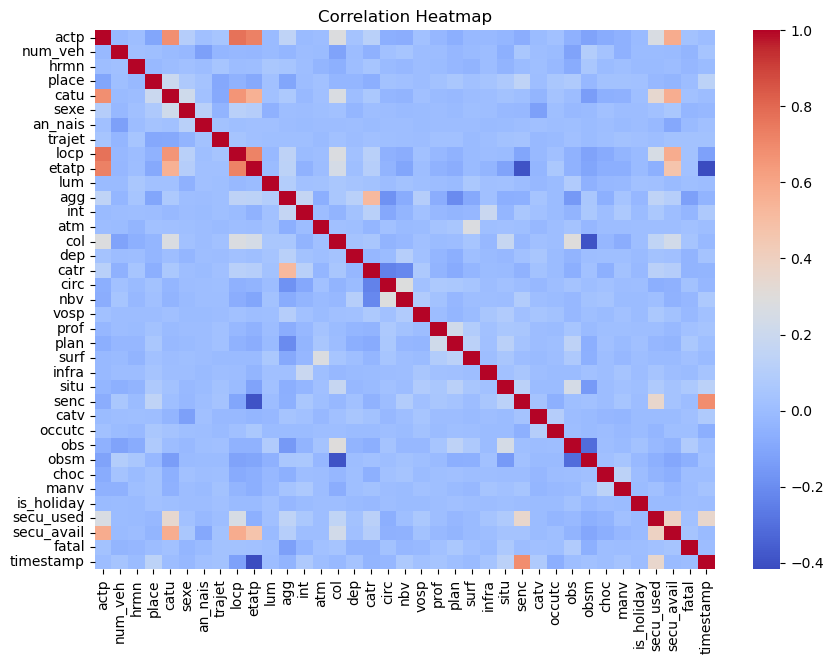

In [15]:
# Create a correlation matrix
correlation_matrix = df_numeric_scaled.corr()
plt.figure(figsize=(10, 7))
# Generate the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

# Add a title
plt.title('Correlation Heatmap')

# Display the plot
plt.show();

### Preparatin of the training and test datasets
#### Split data
The dataset is split by year slides. The years 2005 to 2019 are selected for the train dataset and the years 2020 and 2021 for the test dataset.


In [16]:
# split the dataset to train and test data
X_train = df_encoded.loc[df_encoded['an'] < 2020].drop('fatal', axis = 1)
X_test = df_encoded.loc[df_encoded['an'] > 2019].drop('fatal', axis = 1)

y_train = df_encoded['fatal'].loc[df_encoded['an'] < 2020]
y_test = df_encoded['fatal'].loc[df_encoded['an'] > 2019]

#### Create xgboost matrices
xgboost requires a specific matrix format.

In [40]:
# Create the xgb matrices
train = xgb.DMatrix(data=X_train, label=y_train)
test = xgb.DMatrix(data=X_test, label=y_test)

In [41]:
params = {'booster': 'gbtree', 'learning_rate': 1, 'objective': 'binary:logistic'}

xgb1 = xgb.train(params=params, dtrain=train, num_boost_round=100, evals=[(train, 'train'), (test, 'test')])

[0]	train-logloss:0.12234	test-logloss:0.12413
[1]	train-logloss:0.10297	test-logloss:0.10422
[2]	train-logloss:0.09654	test-logloss:0.09813
[3]	train-logloss:0.09406	test-logloss:0.09583
[4]	train-logloss:0.09301	test-logloss:0.09514
[5]	train-logloss:0.09202	test-logloss:0.09497
[6]	train-logloss:0.09127	test-logloss:0.09383
[7]	train-logloss:0.09070	test-logloss:0.09344
[8]	train-logloss:0.09028	test-logloss:0.09327
[9]	train-logloss:0.08990	test-logloss:0.09333
[10]	train-logloss:0.08971	test-logloss:0.09374
[11]	train-logloss:0.08971	test-logloss:0.09356
[12]	train-logloss:0.08939	test-logloss:0.09332
[13]	train-logloss:0.08893	test-logloss:0.09330
[14]	train-logloss:0.08864	test-logloss:0.09349
[15]	train-logloss:0.08836	test-logloss:0.09354
[16]	train-logloss:0.08809	test-logloss:0.09357
[17]	train-logloss:0.08781	test-logloss:0.09370
[18]	train-logloss:0.08762	test-logloss:0.09358
[19]	train-logloss:0.08733	test-logloss:0.09464
[20]	train-logloss:0.08703	test-logloss:0.09494
[2

In [42]:
params = {'booster': 'gbtree', 'learning_rate': 0.01, 'objective': 'binary:logistic'}

xgb2 = xgb.train(params=params, dtrain=train, num_boost_round=700, evals=[(train, 'train'), (test, 'test')])

[0]	train-logloss:0.18925	test-logloss:0.18656
[1]	train-logloss:0.18813	test-logloss:0.18554
[2]	train-logloss:0.18703	test-logloss:0.18454
[3]	train-logloss:0.18594	test-logloss:0.18354
[4]	train-logloss:0.18487	test-logloss:0.18256
[5]	train-logloss:0.18381	test-logloss:0.18159
[6]	train-logloss:0.18277	test-logloss:0.18064
[7]	train-logloss:0.18173	test-logloss:0.17969
[8]	train-logloss:0.18071	test-logloss:0.17876
[9]	train-logloss:0.17971	test-logloss:0.17783
[10]	train-logloss:0.17871	test-logloss:0.17692
[11]	train-logloss:0.17773	test-logloss:0.17602
[12]	train-logloss:0.17676	test-logloss:0.17513
[13]	train-logloss:0.17581	test-logloss:0.17424
[14]	train-logloss:0.17486	test-logloss:0.17338
[15]	train-logloss:0.17393	test-logloss:0.17251
[16]	train-logloss:0.17300	test-logloss:0.17165
[17]	train-logloss:0.17209	test-logloss:0.17081
[18]	train-logloss:0.17119	test-logloss:0.16997
[19]	train-logloss:0.17030	test-logloss:0.16914
[20]	train-logloss:0.16942	test-logloss:0.16833
[2

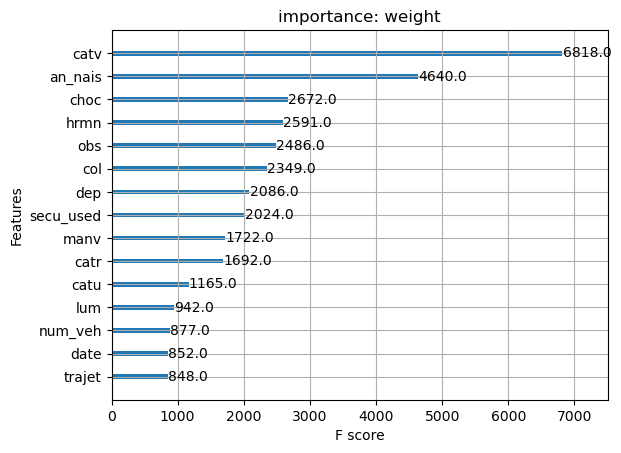

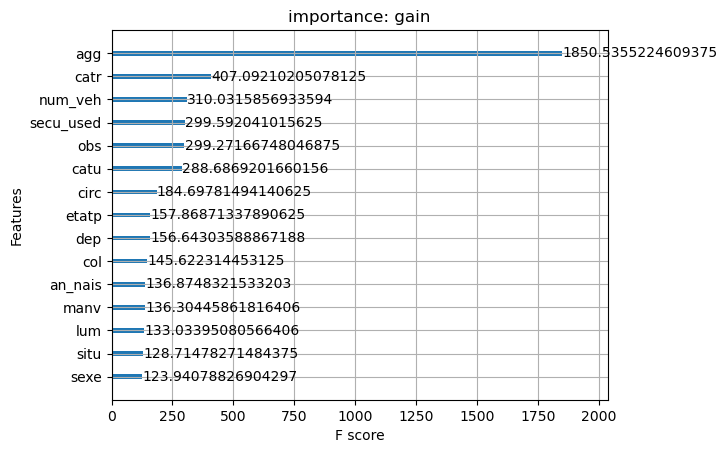

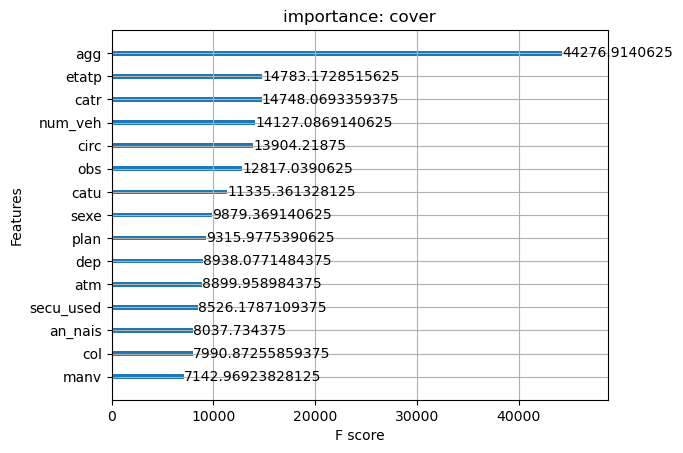

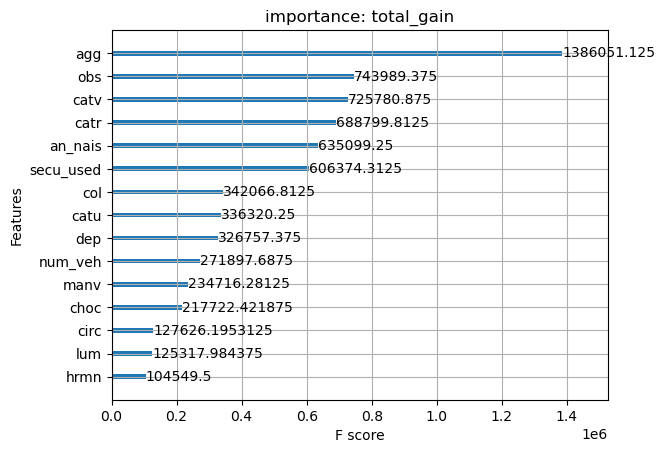

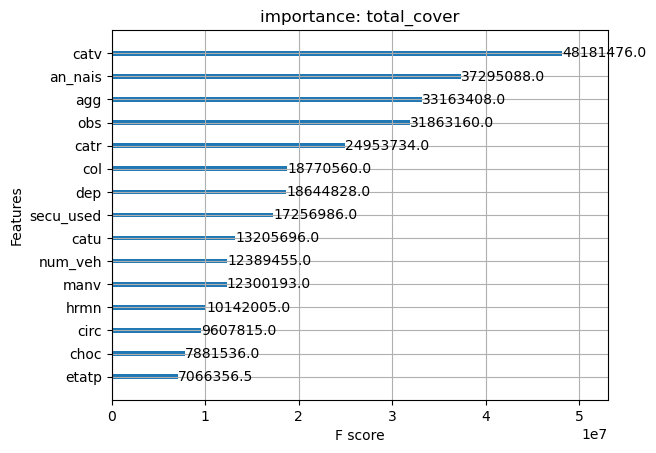

In [44]:
types= ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

for f in types:
    xgb.plot_importance(xgb2, max_num_features=15, importance_type=f, title='importance: '+f);

In [51]:
# specify parameters via map
param = {'booster': 'dart',
         'max_depth': 5, 'learning_rate': 0.1,
         'objective': 'binary:logistic',
         'sample_type': 'uniform',
         'normalize_type': 'tree',
         'rate_drop': 0.1,
         'skip_drop': 0.5}
num_round = 50
xgb3 = xgb.train(param, train, num_round)
preds = bst.predict(test)

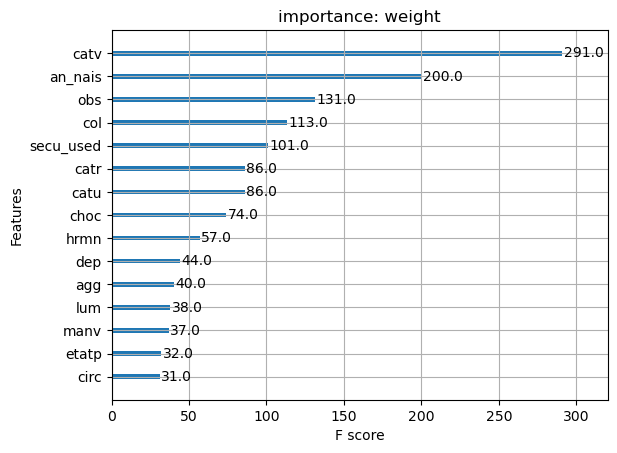

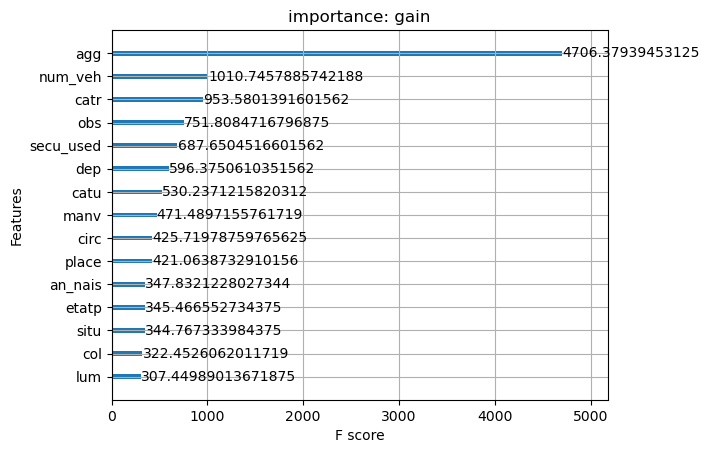

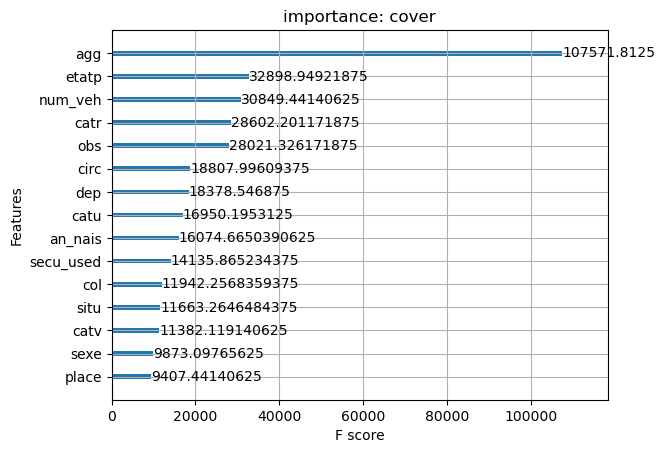

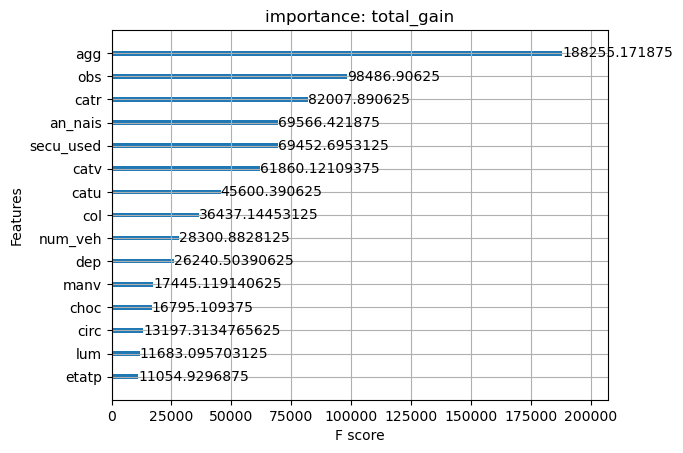

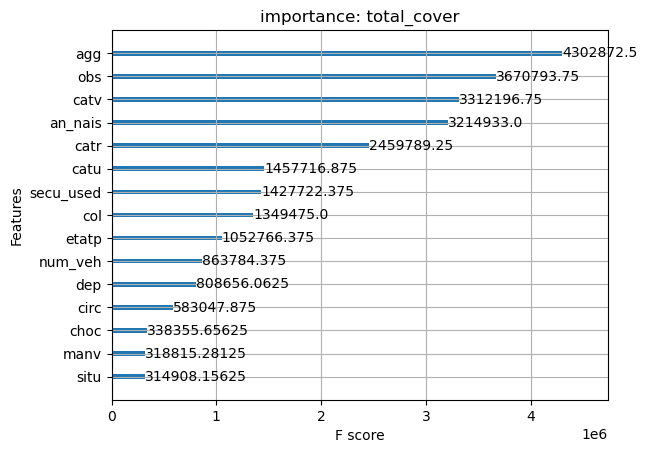

In [52]:
types= ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

for f in types:
    xgb.plot_importance(xgb3, max_num_features=15, importance_type=f, title='importance: '+f);

In [43]:
params = {'booster': 'gbtree', 'learning_rate': 0.01, 'objective': 'binary:logistic'}

bst_cv = xgb.cv(params=params, dtrain=train, nfold=3, num_boost_round=100, early_stopping_rounds=60)

bst_cv

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.189250,0.000158,0.189252,0.000230
1,0.188133,0.000158,0.188137,0.000230
2,0.187031,0.000158,0.187038,0.000230
3,0.185943,0.000158,0.185952,0.000230
4,0.184870,0.000158,0.184880,0.000230
...,...,...,...,...
95,0.126061,0.000195,0.126211,0.000297
96,0.125700,0.000194,0.125851,0.000299
97,0.125342,0.000194,0.125495,0.000300
98,0.124990,0.000194,0.125144,0.000300


In [46]:
preds = xgb2.predict(test)

xgbpreds = pd.Series(np.where(preds > 0.5, 1, 0))

pd.crosstab(xgbpreds, pd.Series(y_test))


ValueError: cannot reindex on an axis with duplicate labels

In [47]:
xgb2.eval(valid)

NameError: name 'valid' is not defined